<a href="https://colab.research.google.com/github/divya18k/Alchemy-AI/blob/main/AI_for_Alzheimers_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Install the 'pyarrow' library which is needed to read parquet files
!pip install pyarrow

# Import the pandas library
import pandas as pd

# Load the dataset from the uploaded parquet file
df = pd.read_parquet('train.parquet')

# --- Initial Inspection ---
# Display the first 5 rows of the dataframe to see what the data looks like
print("First 5 rows of the dataset:")
display(df.head())

# Get a concise summary of the dataframe (columns, data types, missing values)
print("\nDataset Information:")
df.info()

# Get summary statistics for the numerical columns
print("\nSummary Statistics:")
display(df.describe())



First 5 rows of the dataset:


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5120 non-null   object
 1   label   5120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.1+ KB

Summary Statistics:


,label
count,5120.000000
mean,2.055469
std,0.959244
min,0.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

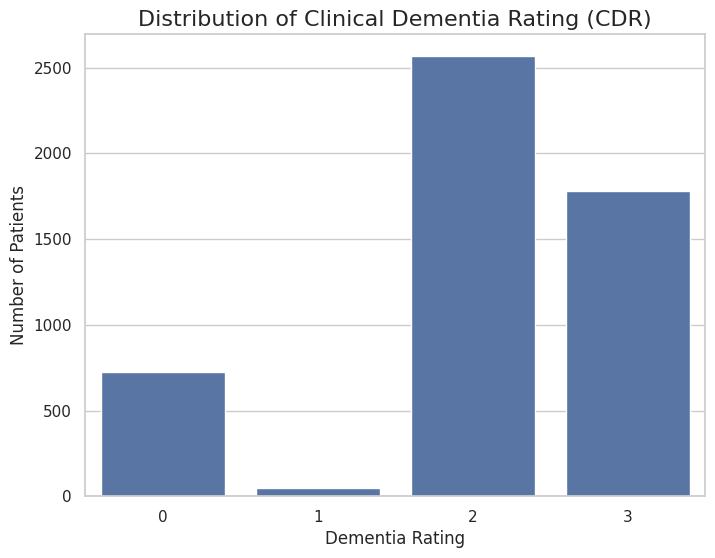


Number of patients in each category:
label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64


In [30]:
# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt


target_column = 'label'

sns.set(style="whitegrid")


plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=df)


plt.title('Distribution of Clinical Dementia Rating (CDR)', fontsize=16)
plt.xlabel('Dementia Rating', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.show()
print("\nNumber of patients in each category:")
print(df[target_column].value_counts())

In [31]:
# Import the numpy library, which is essential for numerical operations
import numpy as np

# --- Inspect the first image entry ---

# Select the very first image from the 'image' column
first_image_data = df['image'].iloc[0]

print("--- Inspecting a Single Image ---")

# Print the data type of the entry
print(f"The data type of a single entry in the 'image' column is: {type(first_image_data)}")

# The image data is often stored inside a dictionary. Let's check if it is.
# If it is a dictionary, we'll print its keys to see what's inside.
if isinstance(first_image_data, dict):
    print(f"The image entry is a dictionary with keys: {first_image_data.keys()}")
    # The actual pixel data is commonly stored under a key like 'bytes'.
    # We will assume this structure for now.
    # Let's try to access the pixel data and check its properties
    # Note: This part might need adjustment based on the actual keys printed above
    # For now, we will try to get the raw bytes and convert them to a numerical array later.
    pass # We will visualize it in the next step.

else:
    # If it's not a dictionary, it might be a different format like a list or array
    # Let's convert it to a NumPy array to check its shape
    first_image_as_array = np.array(first_image_data)
    print(f"The shape of the image data is: {first_image_as_array.shape}")

--- Inspecting a Single Image ---
The data type of a single entry in the 'image' column is: <class 'dict'>
The image entry is a dictionary with keys: dict_keys(['bytes', 'path'])


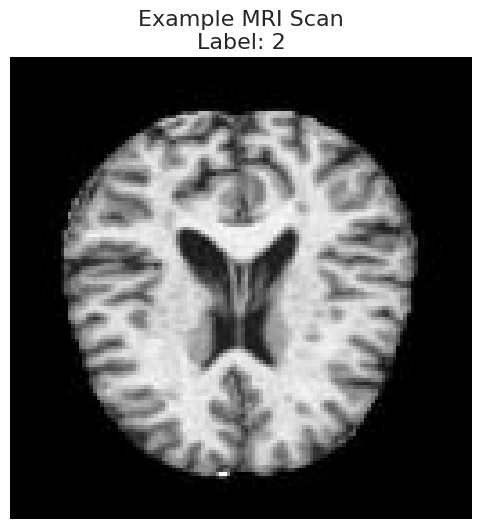

The dimensions of this image are: (128, 128)


In [32]:
# Import libraries needed for image processing and display
import matplotlib.pyplot as plt
from PIL import Image
import io

# --- Visualize the first image from the dataset ---

# Get the first row of data
first_row = df.iloc[0]

# Extract the image bytes and the label from that row
image_bytes = first_row['image']['bytes']
image_label = first_row['label']

# Create an image object from the bytes
# The 'io.BytesIO' function treats the raw bytes like a file
mri_image = Image.open(io.BytesIO(image_bytes))

# --- Display the image ---
plt.figure(figsize=(6, 6))
plt.imshow(mri_image, cmap='gray') # 'cmap=gray' is important for medical images
plt.title(f'Example MRI Scan\nLabel: {image_label}', fontsize=16)
plt.axis('off') # Hide the x and y axis numbers
plt.show()

# Also print the dimensions of the image
print(f"The dimensions of this image are: {mri_image.size}")

In [33]:
# Import necessary libraries
import numpy as np
from PIL import Image
import io
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# --- Step 1: Define a function to process each image dictionary ---
def process_image(image_dict):
    """Extracts bytes, opens image, and converts to a NumPy array."""
    image_bytes = image_dict['bytes']
    image = Image.open(io.BytesIO(image_bytes))
    image_array = np.array(image)
    return image_array

# --- Step 2: Apply this function to every row in the dataframe ---
# tqdm will create a progress bar so we can see it's working.
print("Processing all images into numerical arrays...")
tqdm.pandas()
image_arrays = df['image'].progress_apply(process_image)
print("Image processing complete.")

# --- Step 3: Create the feature matrix (X) and normalize ---
# Stack all the 2D image arrays into a single 3D NumPy array
X = np.stack(image_arrays.values)

# Normalize pixel values from [0, 255] to [0, 1] for better model performance
X = X / 255.0

# Add a 'channel' dimension at the end. Deep learning models for images expect this.
# For grayscale images, the channel dimension is 1.
X = X[..., np.newaxis]

# --- Step 4: Create the target vector (y) ---
y = df['label'].values

# --- Step 5: Split the data into training and testing sets ---
# We'll use 80% for training and 20% for testing.
# 'stratify=y' is VERY important here. It ensures that the proportion of each label
# is the same in both the training and testing sets, which is crucial for our imbalanced dataset.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42, # Ensures the split is the same every time we run it
    stratify=y
)

# --- Final Check: Print the shapes of our new datasets ---
print("\n--- Data Preprocessing Summary ---")
print(f"Shape of all images (X): {X.shape}")
print(f"Shape of all labels (y): {y.shape}")
print("---")
print(f"Shape of training images (X_train): {X_train.shape}")
print(f"Shape of training labels (y_train): {y_train.shape}")
print(f"Shape of testing images (X_test): {X_test.shape}")
print(f"Shape of testing labels (y_test): {y_test.shape}")

Processing all images into numerical arrays...


100%|██████████| 5120/5120 [00:01<00:00, 3579.66it/s]


Image processing complete.

--- Data Preprocessing Summary ---
Shape of all images (X): (5120, 128, 128, 1)
Shape of all labels (y): (5120,)
---
Shape of training images (X_train): (4096, 128, 128, 1)
Shape of training labels (y_train): (4096,)
Shape of testing images (X_test): (1024, 128, 128, 1)
Shape of testing labels (y_test): (1024,)


In [34]:
# Import the necessary components from TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# --- Step 1: Define the model architecture ---

# Find the number of unique classes/labels from our training data
# This is likely 4 (for labels 0, 1, 2, 3)
num_classes = len(np.unique(y_train))
# Get the image dimensions from our training data shape
input_shape = X_train.shape[1:] # Should be (128, 128, 1)

# Initialize a Sequential model
model = Sequential()

# Add the first Convolutional block
# This layer looks for 32 different basic features (like edges)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the second Convolutional block
# This layer looks for 64 more complex features
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a Dropout layer to prevent the model from "memorizing" the training data
model.add(Dropout(0.25))

# Flatten the 2D image data into a 1D vector to feed into the final layers
model.add(Flatten())

# Add a Dense (fully connected) layer for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Add the final Output layer
# It has 'num_classes' neurons, one for each possible diagnosis
# 'softmax' activation ensures the output is a probability distribution
model.add(Dense(num_classes, activation='softmax'))

# --- Step 2: Compile the model ---
# This configures the model for training by specifying the optimizer, loss function, and metrics
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Use this loss for integer labels
              metrics=['accuracy'])

# --- Step 3: Print the model summary ---
# This shows us a table of our model's architecture
print("--- Model Architecture Summary ---")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Model Architecture Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,260 (28.20 MB)

 Trainable params: 7,392,260 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Import the function to calculate class weights
from sklearn.utils.class_weight import compute_class_weight

# --- Step 1: Calculate class weights for our imbalanced dataset ---
# This ensures the model pays more attention to the minority classes (dementia cases)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Convert the weights into a dictionary that Keras can understand
class_weight_dict = dict(enumerate(class_weights))

print("--- Calculated Class Weights ---")
print(class_weight_dict)
print("\n--- Starting Model Training ---")

# --- Step 2: Train the model ---
# We will train for 20 epochs. An epoch is one full pass through the entire training dataset.
# The 'history' object will store the training progress (like accuracy and loss) after each epoch.
history = model.fit(
    X_train,
    y_train,
    batch_size=32,          # Process images in batches of 32
    epochs=20,              # Train for 20 full cycles
    validation_data=(X_test, y_test), # Use the test set to check performance
    class_weight=class_weight_dict # Apply the weights to handle imbalance
)

print("\n--- Model Training Complete ---")

--- Calculated Class Weights ---
{0: np.float64(1.768566493955095), 1: np.float64(26.256410256410255), 2: np.float64(0.4987822698490015), 3: np.float64(0.7185964912280701)}

--- Starting Model Training ---
Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 101s 760ms/step - accuracy: 0.1223 - loss: 1.6473 - val_accuracy: 0.2354 - val_loss: 1.3855
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 97s 756ms/step - accuracy: 0.2568 - loss: 1.3812 - val_accuracy: 0.5225 - val_loss: 1.3543
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 140s 738ms/step - accuracy: 0.2125 - loss: 1.4406 - val_accuracy: 0.4932 - val_loss: 1.3357
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 137s 693ms/step - accuracy: 0.3899 - loss: 1.2822 - val_accuracy: 0.4883 - val_loss: 1.1586
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 147s 734ms/step - accuracy: 0.4451 - loss: 1.1316 - val_accuracy: 0.5811 - val_loss: 0.9625
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 90s 707ms/step - accuracy: 0.5471 - loss: 0.8099 - val_accuracy: 0.5957 - val_loss: 0.9062
Epoc

--- Plotting Model Performance ---


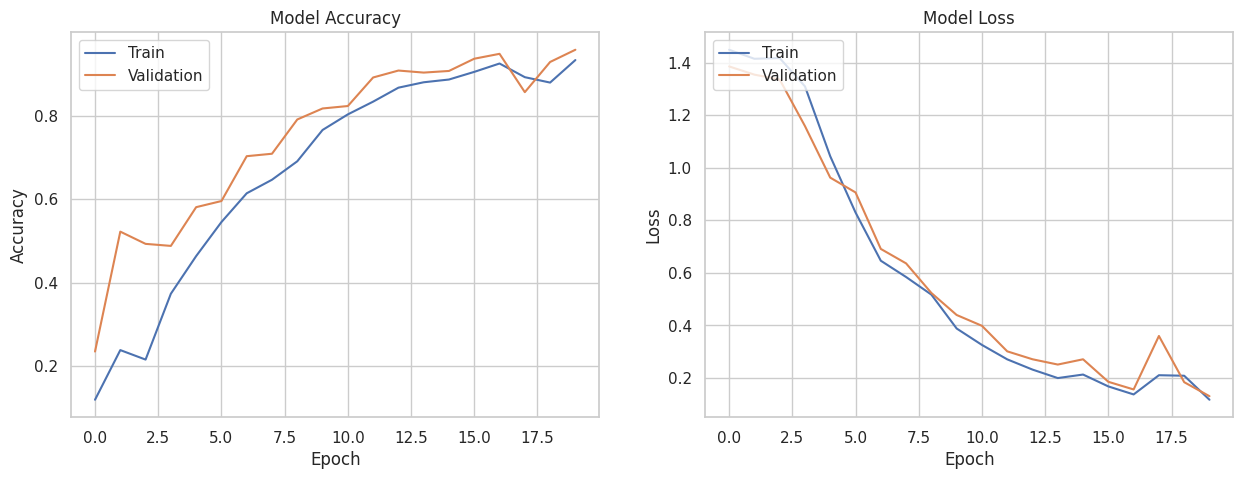


--- Evaluating on Unseen Test Data ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95       145
     Class 1       1.00      1.00      1.00        10
     Class 2       0.97      0.97      0.97       513
     Class 3       0.95      0.95      0.95       356

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024


Confusion Matrix:


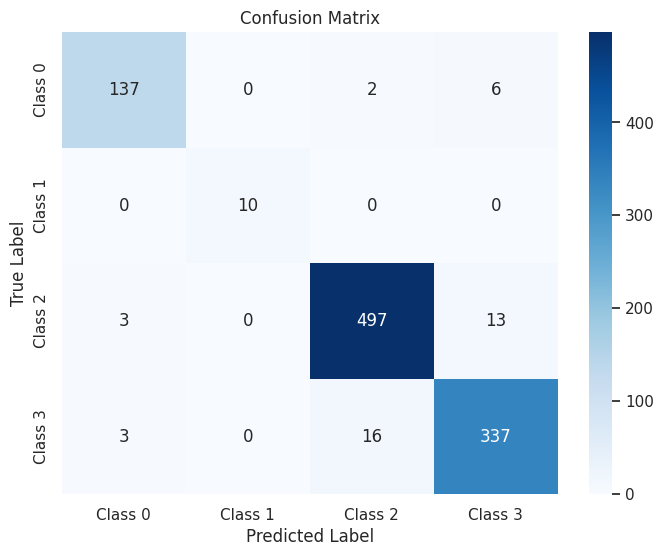

In [36]:
# Import necessary libraries for evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Step 1: Visualize Training History (Accuracy and Loss) ---

print("--- Plotting Model Performance ---")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# --- Step 2: Evaluate on the Test Set and Generate Reports ---

print("\n--- Evaluating on Unseen Test Data ---")

# Get the model's predictions on the test set
y_pred_probabilities = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Print the Classification Report
# This shows precision, recall, and F1-score for each class
print("\nClassification Report:")
# Get the names of the labels (e.g., 'Class 0', 'Class 1', ...)
class_labels = [f"Class {i}" for i in np.unique(y_train)]
print(classification_report(y_test, y_pred_classes, target_names=class_labels))


# --- Step 3: Generate and Plot the Confusion Matrix ---
print("\nConfusion Matrix:")
# A confusion matrix shows correct vs. incorrect predictions for each class
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()